In [173]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon 

In [174]:
class BuckleyLev():
    
    def __init__(self):
        self.params = {
            #non wetting phase viscosity
            "viscosity_o": 1.e-3,
            #wetting phase viscosity
            "viscosity_w": 1.e-3,
            #initial water sat
            "initial_sw":0,
            #residual water saturation,
            "residual_w":0.1,
            #residual oil saturation,
            "residual_o":0.2,
            #water rel perm at water curve end point
            "krwe":0.7,
            #oil rel perm at oil curve end point
            "kroe": 0.99
        }

In [175]:
def k_rw(self,sw):
    #water relative perm calculation for a given water saturation 
    p = 11.174
    return ((self.params['krwe']))*sw**p

BuckleyLev.k_rw = k_rw

In [176]:
def k_rn(self,sw):
    #oil relative perm calculation for a given water saturation 
    q = 3.326
    return ((1.-self.params['kroe']*sw)**q)

BuckleyLev.k_rn = k_rn

In [177]:
def fractional_flow(self,sw):
    #returns the fractional flow
    
    return 1./(1.+((self.k_rn(sw)/self.k_rw(sw))*(self.params["viscosity_w"]/self.params["viscosity_o"])))

BuckleyLev.fractional_flow = fractional_flow

In [178]:
def fractional_flow_deriv(self,sw):
    #calculate derivative of fractional flow - dFw/dSw - Vsh
    
    f_deriv = (self.fractional_flow(sw+0.0001) - self.fractional_flow(sw))/0.0001
    
    return f_deriv

BuckleyLev.fractional_flow_deriv = fractional_flow_deriv

In [179]:
def plot_fractional_flow_deriv(self):
    #plot the derivative dFw/dSw - Vsh vs Sw
    y = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)
    x = [self.fractional_flow_deriv(i) for i in y ]
    
    plt.plot(x,y)
    plt.title('Derivative of fractional flow curve')
    plt.xlabel('dfw/dSw')
    plt.ylabel('Sw')
    plt.show()
    
BuckleyLev.plot_fractional_flow_deriv=plot_fractional_flow_deriv

In [180]:
def sw_at_shock_front(self):
    #first find range to search in by looking where 2nd derivative is negative (where curve turns)
    
    sw_start = 1.-self.params['residual_o']
    sw_end = self.params['residual_w']
    
    
    for sw in np.arange(self.params['residual_w']+1.e-9, 1.-self.params['residual_o'],0.001):
        if (self.fractional_flow_2deriv(sw)< -1.e-2 and sw < sw_start):
            #i.e. we are below sw_start and the grad is negative - update upper limit
            sw_start = sw
        if (self.fractional_flow_2deriv(sw)< -1.e-2 and sw > sw_end):
            # i.e. we are above sw_end and the gradient is negative - update lower limit
            sw_end = sw
        else:
            sw_at_front = 0.
            current_min = 1000.
        
            #find where finite difference approximation (almost) equals the continuous value of the function
    for sw in np.arange(sw_start,sw_end, 0.0001):
        
        current_diff = abs(self.fractional_flow_deriv(sw)-self.fractional_flow(sw)/sw)
        #print( 'grad func',self.fractional_flow_deriv(sw),sw,self.fractional_flow(sw)/sw)
        print('approx',self.fractional_flow(sw)/sw, sw)
        if current_diff < current_min:
            #print('sw at front',current_min, sw,current_diff)
            current_min = current_diff
            sw_at_front = sw
                
            current_min = current_diff
                    
    return sw_at_front
BuckleyLev.sw_at_shock_front = sw_at_shock_front

In [181]:
def plot_fractional_flow(self):
    #plot the sw vs fractional flow
    
    x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)
    y = [self.fractional_flow(i) for i in x ]
    
    plt.plot(x,y)
    
    sw_at_front = self.sw_at_shock_front()
    plt.plot([sw_at_front],[self.fractional_flow(sw_at_front)],'ro')
    
    plt.title('Fractional flow as a function of water saturation')
    plt.xlabel('Sw')
    plt.ylabel('Fractional flow')
    
    plt.show()
    
BuckleyLev.plot_fractional_flow = plot_fractional_flow

In [182]:
def fractional_flow_2deriv(self,sw):
    f_2deriv = ((self.fractional_flow(sw+0.01))-2*(self.fractional_flow(sw))-self.fractional_flow(sw-0.01))/((0.01)**2)
    return f_2deriv

BuckleyLev.fractional_flow_2deriv = fractional_flow_2deriv

In [183]:
a = BuckleyLev()
#a.plot_fractional_flow()
#a.plot_fractional_flow_deriv()
#a.sw_at_shock_front()


In [184]:
def displacement_plot(self):
    #using the shock front velocity, plot the displacement profile
    v_sh = self.sw_at_shock_front()
    
    y = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)
    x = [self.fractional_flow_deriv(i) for i in y if self.fractional_flow_deriv(i)>v_sh ]
    x = [x for x in x if ]

    return x
BuckleyLev.displacement_plot = displacement_plot

SyntaxError: invalid syntax (<ipython-input-184-694dfd2eefdf>, line 7)

In [ ]:
a.displacement_plot()

In [ ]:
x = [0.34515032411008839,
 0.58300106927221262,
 0.96800379159621419,
 1.5693554144293533,
 2.4561766717509648,
 3.6464038686046529,
 5.0121210425025371,
 6.2001111874847021,
 6.727686174101466,
 6.3186101190487731,
 5.1607154153902046,
 3.7385562003204864,
 2.4643169685046873,
 1.5119874927932431,
 0.87693503513319726,
 0.48426662278056032]
current_max = 0
new_list = []
for index, item in enumerate(x):
    if (x[index]<=x[index+1]):
        new_list.append(x[index+1])
    else:
        break
        
print(new_list)
new_list = filter(lambda (index,item): item == current_max,enumerate(x))
new_list = filter(lambda (index,item): item == max(x),enumerate(x))


In [185]:
def rarefaction(self):
    # it should calculate the shock velocity and the corresponding saturation which this occurs an
    
    #create dx window of increasing size for calculating welge
    x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)
    
    maximum, sw_shock = 0,0
    grads = []
    
    ## calculate welge gradient at each point until we find the max = shock velocity
    for swi in x:
        grad = self.fractional_flow(swi)/(swi-self.params["residual_w"]+1e-3)
        grads.append(grad)
        
        if grad>maximum:
            sw_shock = swi
            maximum = grad
            
    #find the position of the shock velocity in the grads array and slice to this point for the rarefaction 
    #plus one to include the actual shock velocity
    rarefaction = grads[:([i for i,x in enumerate(grads) if x == maximum][0]+1)]
    
    return(sw_shock,maximum, rarefaction)
    
BuckleyLev.rarefaction = rarefaction

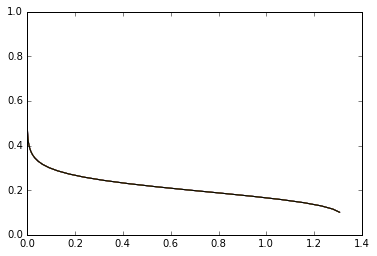

In [199]:
y = np.linspace(a.params["residual_w"]+1e-3,(1-a.params["residual_o"]+1e-3),50)[:(len(x))]
x = a.rarefaction()[2]
x.sort(reverse=True)
plt.plot(x,y)
plt.ylim([0,1])
plt.show()

In [196]:
x = np.linspace(a.params["residual_w"]+1e-3,(1-a.params["residual_o"]+1e-3),50)
grads = map(lambda (index, swi): a.fractional_flow(swi)/(swi-a.params["residual_w"]+1e-3) ,enumerate(x))

In [67]:
#reduce(lambda item,accum: item if (item>accum) else accum ,grads)
#filter(lambda (item,iter): item>item[iter-1] ,enumerate(grads))
reduce(lambda item,accum:  accum,grads)

0.99800376989047002

In [111]:
c[0][:[i for i,x in enumerate(c[0]) if x == c[2]][0]]


[1.0555985171873555e-31,
 7.439251471259825e-18,
 7.4042084864082389e-15,
 4.5685432294991604e-13,
 8.8360010056319082e-12,
 9.0090655953176873e-11,
 6.1189686964991084e-10,
 3.1391354631025245e-09,
 1.3115646634414593e-08,
 4.6859245982700724e-08,
 1.4802460157222927e-07,
 4.2343397878323237e-07,
 1.1164542415015989e-06,
 2.7501845203759121e-06,
 6.396252522829e-06,
 1.4163812941259775e-05,
 3.0066683767769093e-05,
 6.152928040591584e-05,
 0.00012195782970164976,
 0.00023507016555416723,
 0.00044210559336879755,
 0.00081372116016860201,
 0.0014694695895603404,
 0.0026094654940107074,
 0.0045654740513758471,
 0.0078825037377451852,
 0.013447062726465368,
 0.022683274136170117,
 0.037837718012137637,
 0.062352180276312175,
 0.10124140211105588,
 0.16117891501218773,
 0.24959474685979291,
 0.37173937426879866,
 0.52541837159451643,
 0.69631484598048288,
 0.86015048268563321,
 0.99362149403855515,
 1.0852893283595302,
 1.1370628125859281,
 1.1581620510843109]

In [155]:
x = a.rarefaction()[2]
x.sort(reverse=True)
x

[1.1588480288892082,
 1.1581620510843109,
 1.1370628125859281,
 1.0852893283595302,
 0.99362149403855515,
 0.86015048268563321,
 0.69631484598048288,
 0.52541837159451643,
 0.37173937426879866,
 0.24959474685979291,
 0.16117891501218773,
 0.10124140211105588,
 0.062352180276312175,
 0.037837718012137637,
 0.022683274136170117,
 0.013447062726465368,
 0.0078825037377451852,
 0.0045654740513758471,
 0.0026094654940107074,
 0.0014694695895603404,
 0.00081372116016860201,
 0.00044210559336879755,
 0.00023507016555416723,
 0.00012195782970164976,
 6.152928040591584e-05,
 3.0066683767769093e-05,
 1.4163812941259775e-05,
 6.396252522829e-06,
 2.7501845203759121e-06,
 1.1164542415015989e-06,
 4.2343397878323237e-07,
 1.4802460157222927e-07,
 4.6859245982700724e-08,
 1.3115646634414593e-08,
 3.1391354631025245e-09,
 6.1189686964991084e-10,
 9.0090655953176873e-11,
 8.8360010056319082e-12,
 4.5685432294991604e-13,
 7.4042084864082389e-15,
 7.439251471259825e-18,
 1.0555985171873555e-31]

In [102]:
[i for i,x in enumerate(c[0]) if x == c[2]][0]

41

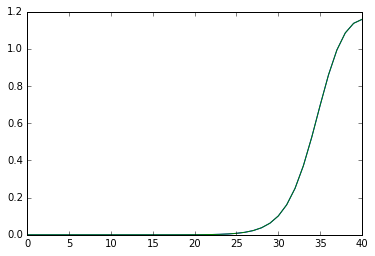

In [105]:
plt.plot(,c[0][:[i for i,x in enumerate(c[0]) if x == c[2]][0]])
plt.show()

In [110]:
c

([1.0555985171873555e-31,
  7.439251471259825e-18,
  7.4042084864082389e-15,
  4.5685432294991604e-13,
  8.8360010056319082e-12,
  9.0090655953176873e-11,
  6.1189686964991084e-10,
  3.1391354631025245e-09,
  1.3115646634414593e-08,
  4.6859245982700724e-08,
  1.4802460157222927e-07,
  4.2343397878323237e-07,
  1.1164542415015989e-06,
  2.7501845203759121e-06,
  6.396252522829e-06,
  1.4163812941259775e-05,
  3.0066683767769093e-05,
  6.152928040591584e-05,
  0.00012195782970164976,
  0.00023507016555416723,
  0.00044210559336879755,
  0.00081372116016860201,
  0.0014694695895603404,
  0.0026094654940107074,
  0.0045654740513758471,
  0.0078825037377451852,
  0.013447062726465368,
  0.022683274136170117,
  0.037837718012137637,
  0.062352180276312175,
  0.10124140211105588,
  0.16117891501218773,
  0.24959474685979291,
  0.37173937426879866,
  0.52541837159451643,
  0.69631484598048288,
  0.86015048268563321,
  0.99362149403855515,
  1.0852893283595302,
  1.1370628125859281,
  1.158162

In [134]:
x[:1]

array([ 0.001])